# Table of Contents

[1. Data Importation & Cleaning](#1---data-importation)
- [1.1 - Relevant imports](#relevant-imports)
- [1.2 - Importing the datasets](#importing-the-datasets)
- [1.3 - Reaarangements & new columns](#rearrangements)
- [1.4 - Data cleaning](#data-cleaning)

[2. Exploratory Data Analysis](#2---exploratory-data-analysis)
- [2.1 Visualizing categorical & numerical variables](#visualizing-categorical--numerical-variables)
- [2.2 Visualizing numerical variables]()
- [2.3 Insights]()

## 1 - Data Importation

### Relevant imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Importing the datasets

In [28]:
data_list = []

for a in range(0, 5):
    file_path="data/dataset"+str(a+1)+".csv"
    data_list.append(pd.read_csv(file_path))

new_col_names = ['G (m3/d)', 'P1 (MPa)', 'P2 (MPa)', 'ID (mm)', 'h (m)', 'Loading status']

for df in data_list:
    df.set_index("Well No.", inplace=True)
    df.columns = new_col_names

dataset = pd.DataFrame([])

dataset = pd.concat([df for df in data_list]).reset_index(drop=True).rename_axis('Well No.')

# Check the dataset
# print(dataset.head())

## Rearrangements

The following code:
- imputes missing values for internal diameter using the modal value, since internal diameter is a fixed, constant and precalculated value
- imputes missing values for wellbore pressure using the average pressure difference from rows that have both wellbore and wellhead pressure data
- imputes missing values for well depth using the average value
- creates new columns for
    - pressure difference (delta_P, MPa) - P1 - P2
    - pressure gradient (P_grad, MPa/m) - delta_P / h
    - cross-sectional area of well (CSA, m2) = pi * (ID / 2)**2, converted to relevant units
    - superficial velocity (sup_v, m/s) - G / A, converted to relevant units
- corrects column types

In [29]:
# Impute missing values for ID (mm)
dataset["ID (mm)"].fillna(value=dataset["ID (mm)"].mode().iloc[0], inplace=True)

# Impute missing values for P1 (MPa)
dataset_temp_1 = dataset.dropna(subset=['P1 (MPa)'])
avg_p_diff = (dataset_temp_1['P1 (MPa)'] - dataset_temp_1['P2 (MPa)']).mean()
dataset["P1 (MPa)"].fillna(dataset['P2 (MPa)'] + avg_p_diff, inplace=True)

# Impute missing values for h (m)
dataset_temp_2 = dataset.dropna(subset=['h (m)'])
avg_h = dataset_temp_2['h (m)'].mean()
dataset['h (m)'].fillna(avg_h, inplace=True)

# Create new column, delta_P
dataset['delta_P (MPa)'] = np.abs(dataset['P1 (MPa)'] - dataset['P2 (MPa)'])

# Create new column, P_grad
dataset['P_grad (MPa / m)'] = dataset['delta_P (MPa)'] / dataset['h (m)']

# Create new column, CSA (m2)
dataset['CSA (m2)'] = dataset['ID (mm)'].apply(lambda x: np.pi * (x/2000)**2)

# Create new column, sup_v (m/s)
dataset['sup_v (m/s)'] = dataset['G (m3/d)'] / (dataset['CSA (m2)'] * 24 * 3600)

# Adjust type of col 'Loading status'
dataset['Loading status'] = dataset['Loading status'].str.strip().astype('category')
dataset["Loading status"] = dataset['Loading status'].cat.set_categories(["Unloaded", "Near Load Up", "Loaded Up"], ordered=True)

print(dataset['Loading status'].value_counts(dropna=False))

final_dataset = dataset.drop(dataset.tail(67).index)
unseen_data = pd.concat([pd.DataFrame([]), dataset.tail(67)]).reset_index(drop=True).rename_axis('Well No.')

final_dataset.info()
unseen_data.info()

# Check dataset
dataset.info()

Loading status
Loaded Up       178
Unloaded         77
Near Load Up      8
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   G (m3/d)          196 non-null    float64 
 1   P1 (MPa)          196 non-null    float64 
 2   P2 (MPa)          196 non-null    float64 
 3   ID (mm)           196 non-null    float64 
 4   h (m)             196 non-null    float64 
 5   Loading status    196 non-null    category
 6   delta_P (MPa)     196 non-null    float64 
 7   P_grad (MPa / m)  196 non-null    float64 
 8   CSA (m2)          196 non-null    float64 
 9   sup_v (m/s)       196 non-null    float64 
dtypes: category(1), float64(9)
memory usage: 14.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------  

### Data cleaning

#### Observations
- a row of data was observed with 0 gas flowrate.  on closer observation, its wellhead pressure was also about 0.6 MPa. As such, calculated values like sup_v were also 0. The well was also marked as `Loaded Up`. This row of data is valid and would be left in the final dataset.
- Wellhead pressure had an extremely high value that should be removed as it significantly skews the mean and median

In [30]:
print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['P1 (MPa)'])
# print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['G (m3/d)'])
# print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['sup_v (m/s)'])
# print("P1 stats before clean (max, min, avg)", dataset['P1 (MPa)'].max(), dataset['P1 (MPa)'].min(), dataset['P1 (MPa)'].mean())
dataset.drop(index=dataset['P1 (MPa)'].idxmax(), inplace=True)
# print("P1 stats after clean (max, min, avg)", dataset['P1 (MPa)'].max(), dataset['P1 (MPa)'].min(), dataset['P1 (MPa)'].mean())

# Check the dataset
# dataset.info()
# dataset.describe()

# observations
print(dataset.loc[dataset['G (m3/d)'].idxmin()])

# Check dataset
dataset.info()
dataset.describe()

240.0
G (m3/d)                  0.0
P1 (MPa)             7.236698
P2 (MPa)                  0.4
ID (mm)               112.014
h (m)                  2000.0
Loading status      Loaded Up
delta_P (MPa)        6.836698
P_grad (MPa / m)     0.003418
CSA (m2)             0.009854
sup_v (m/s)               0.0
Name: 196, dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 0 to 262
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   G (m3/d)          262 non-null    float64 
 1   P1 (MPa)          262 non-null    float64 
 2   P2 (MPa)          262 non-null    float64 
 3   ID (mm)           262 non-null    float64 
 4   h (m)             262 non-null    float64 
 5   Loading status    262 non-null    category
 6   delta_P (MPa)     262 non-null    float64 
 7   P_grad (MPa / m)  262 non-null    float64 
 8   CSA (m2)          262 non-null    float64 
 9   sup_v (m/s)       262 non-null    fl

,G (m3/d),P1 (MPa),P2 (MPa),ID (mm),h (m),delta_P (MPa),P_grad (MPa / m),CSA (m2),sup_v (m/s)
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,45142.421412,14.670388,8.654542,80.712046,2595.970848,6.016609,0.002403,0.005965,176.737976
std,63443.423936,10.758753,9.070066,32.942490,858.670946,3.511155,0.001379,0.005412,267.827287
min,0.000000,0.840000,0.300000,44.000000,685.766500,0.100000,0.000039,0.001521,0.000000
25%,0.000000,7.436698,1.337500,62.000000,2000.000000,3.650000,0.001495,0.003019,0.000000
50%,16787.830000,10.868349,4.595000,62.000000,2487.656000,6.836698,0.002300,0.003019,63.255303
75%,70626.372500,20.699198,14.327500,101.000000,3025.000000,6.836698,0.003275,0.008012,257.264059
max,333123.800000,63.506698,56.670000,188.000000,5100.000000,22.000000,0.009969,0.027759,1480.644572


# 2 - Exploratory Data Analysis

## Visualising Categorical & Numerical Variables


In [31]:
# sns.set_style('dark')
# sns.set_palette('dark')


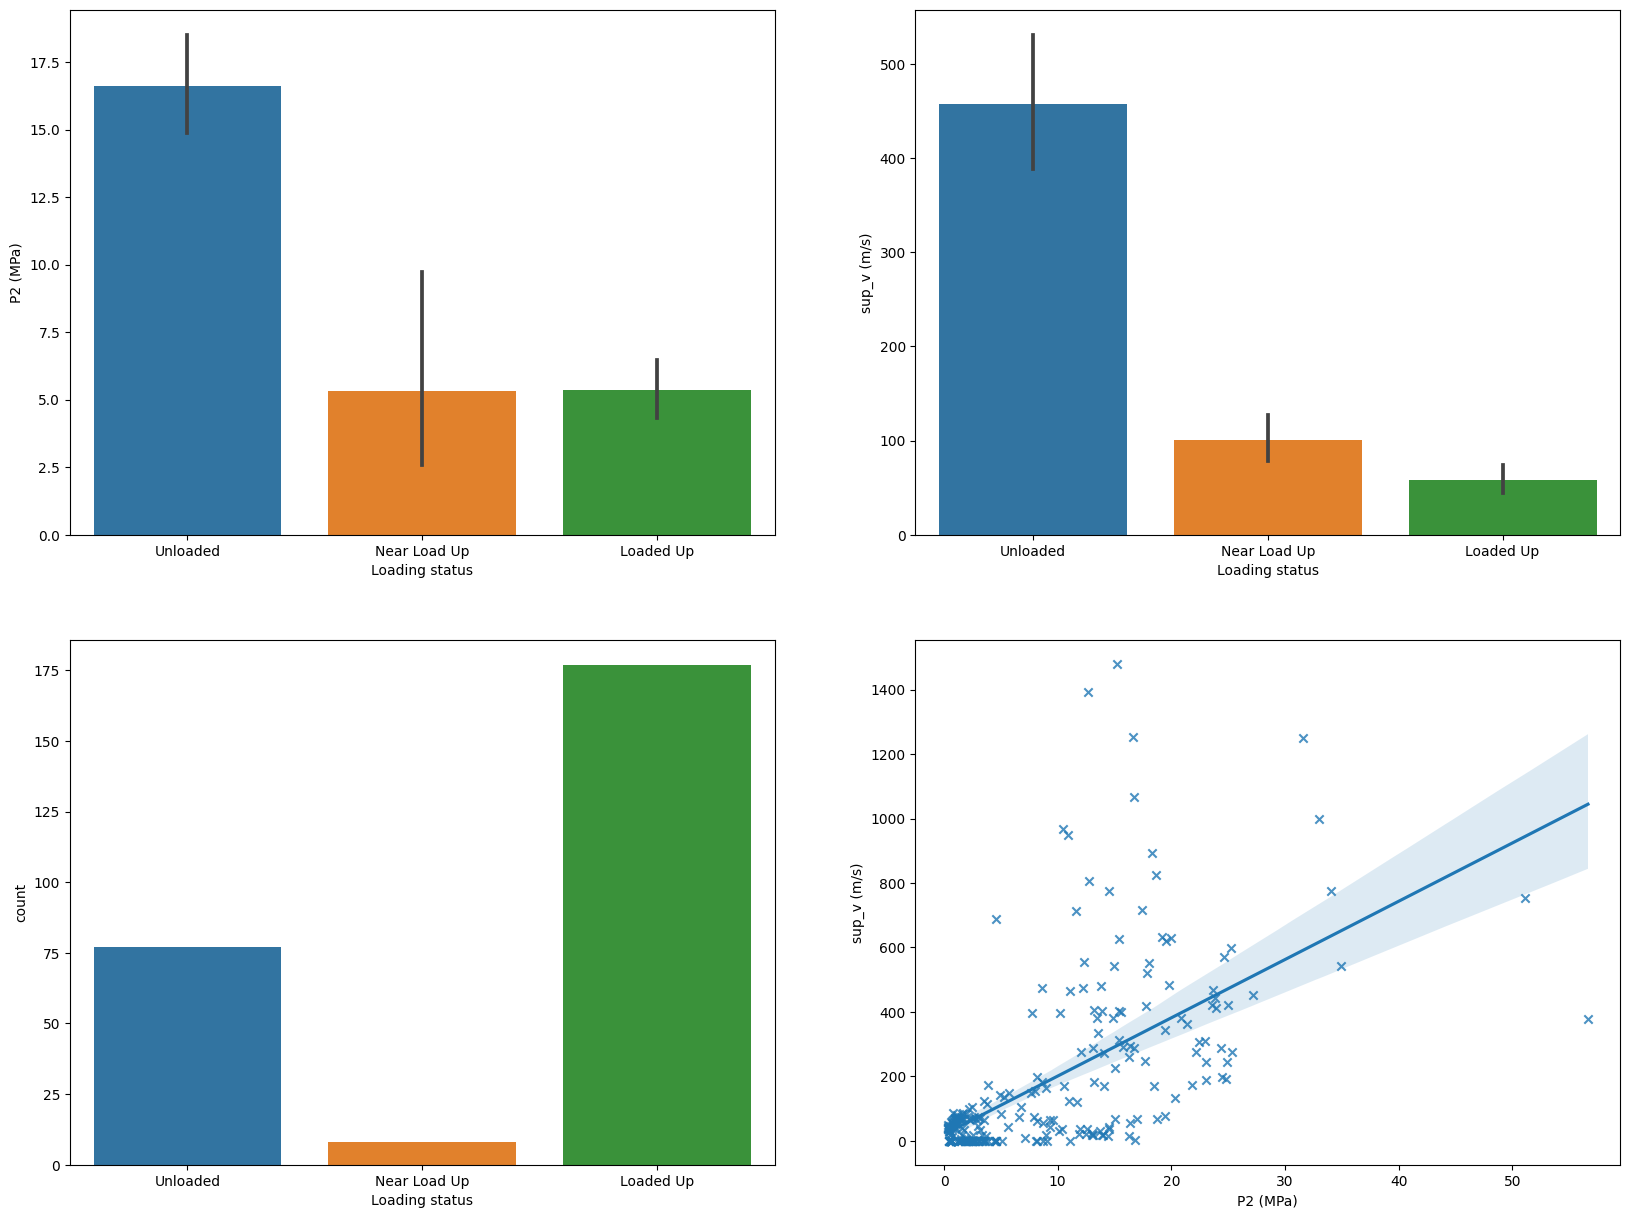

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot(x='Loading status', data=dataset, ax=axes[1, 0])

sns.barplot(x='Loading status', y='P2 (MPa)', data=dataset, ax=axes[0, 0])

sns.barplot(x='Loading status', y='sup_v (m/s)', data=dataset, ax=axes[0, 1])

# sns.stripplot(x='Loading status', y='sup_v (m/s)', data=dataset, ax=axes[1, 1], hue='ID (mm)')

sns.regplot(dataset, x='P2 (MPa)', y='sup_v (m/s)', marker='x', ax=axes[1, 1])

plt.show()

## 2.1 - Visualizing categorical & numerical variables

The charts above show a distinct difference in the wellhead pressure and superficial velocity of loaded wells, near-loaded, and unloaded wells. In both the pressure and superficial velocity bar charts, the loaded and near-loaded wells show a significantly lower value than unloaded wells. The relational plot between wellhead pressure and superficial velocity shows us two major things:
- There is a positive correlation between wellhead pressure and superficial velocity. This holds true whether the well is loaded, near-loaded or unloaded.
- The unloaded wells have much higher values of both wellhead pressure and superficial velocity, while wells marked as near-loaded and loaded have lower values.

This reestablishes the idea that loading is due to a significant reduction in pressure, leading to a drop in superficial velocity

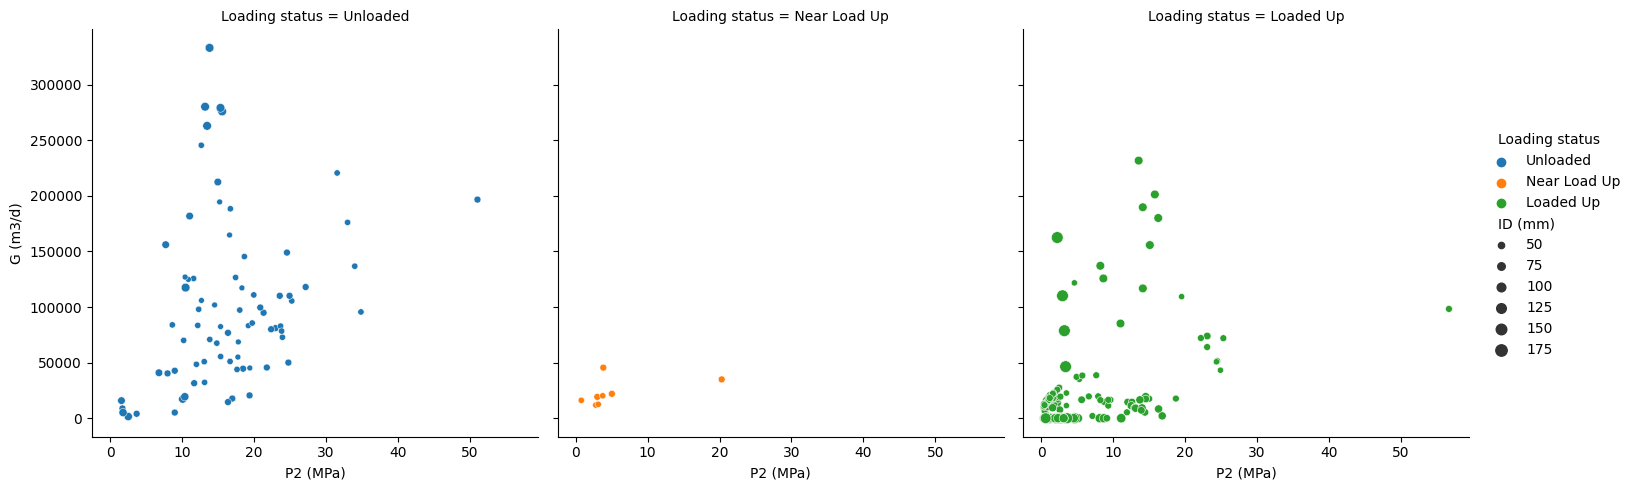

In [33]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.relplot(x="P2 (MPa)", y="G (m3/d)", data=dataset, kind="scatter", size='ID (mm)', col='Loading status', hue="Loading status")

plt.show()

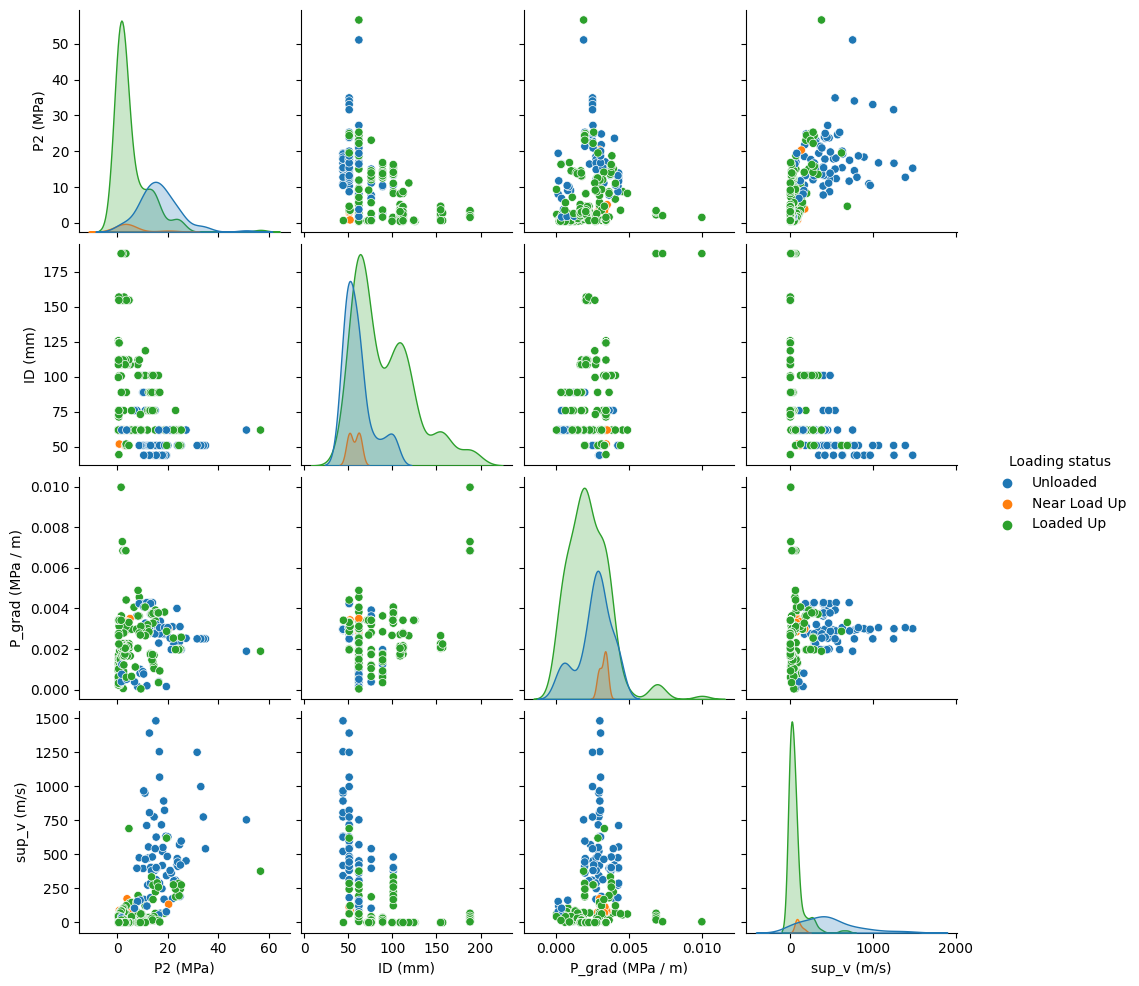

In [34]:
sns.pairplot(dataset.drop(columns=['P1 (MPa)', 'G (m3/d)', 'CSA (m2)', 'delta_P (MPa)', 'h (m)'], axis=1), hue='Loading status')

<Axes: >

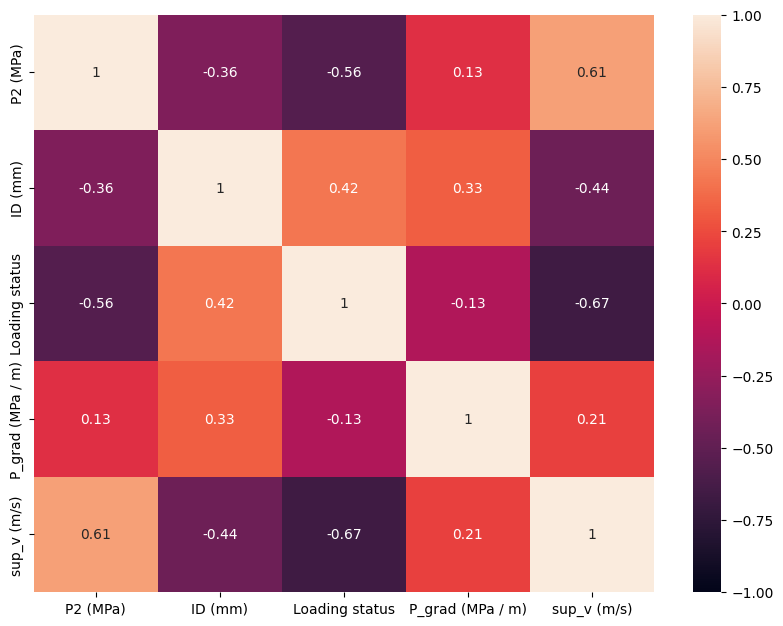

In [35]:
plt.figure(figsize=(10, 7.5))

dataset_heat = dataset.drop(columns=['G (m3/d)', 'CSA (m2)', 'P1 (MPa)', 'delta_P (MPa)', 'h (m)'])
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Loaded Up', '2')
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Near Load Up', '1')
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Unloaded', '0')
dataset_heat['Loading status'] = dataset_heat['Loading status'].astype('category')

sns.heatmap(dataset_heat.corr(), annot=True, vmin=-1, vmax=1)

## Machine Learning

#### Relevant Imports

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#### Data pre-processing

In [37]:
columns_to_keep = ['sup_v (m/s)', 'ID (mm)', 'h (m)', 'P2 (MPa)', 'Loading status']
dataset = dataset[columns_to_keep]
final_dataset = final_dataset[columns_to_keep]
unseen_data = unseen_data[columns_to_keep]

In [38]:
final_dummy = pd.get_dummies(final_dataset['Loading status'])
unseen_dummy = pd.get_dummies(unseen_data['Loading status'])

final_dummy = pd.concat([final_dataset, final_dummy], axis=1)
final_dummy = final_dummy.drop('Loading status', axis=1)
unseen_dummy = pd.concat([unseen_data, unseen_dummy], axis=1)
unseen_dummy = unseen_dummy.drop('Loading status', axis=1)
# final_dummy.info()

### Classification Models

#### RandomForestClassifier

In [44]:
X = final_dataset.drop('Loading status', axis=1).values
y = final_dataset['Loading status'].values
seed = 21

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=seed)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Model Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print("Classification Report: ")
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_matrix)

Classification Model Accuracy: 0.8135593220338984
Classification Report: 
              precision    recall  f1-score   support

   Loaded Up       0.80      0.91      0.85        35
    Unloaded       0.84      0.67      0.74        24

    accuracy                           0.81        59
   macro avg       0.82      0.79      0.80        59
weighted avg       0.82      0.81      0.81        59

Confusion matrix:
[[32  3]
 [ 8 16]]


In [40]:
# RandomForest with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

rf_classifier.fit(X_train_scaled, y_train)

y_pred_scaled = rf_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_scaled)
print(f"Classification Model Accuracy: {accuracy}")

report = classification_report(y_test, y_pred_scaled)
print("Classification Report: ")
print(report)

conf_matrix = confusion_matrix(y_test, y_pred_scaled)
print("Confusion matrix:")
print(conf_matrix)

Classification Model Accuracy: 0.8135593220338984
Classification Report: 
              precision    recall  f1-score   support

   Loaded Up       0.80      0.91      0.85        35
    Unloaded       0.84      0.67      0.74        24

    accuracy                           0.81        59
   macro avg       0.82      0.79      0.80        59
weighted avg       0.82      0.81      0.81        59

Confusion matrix:
[[32  3]
 [ 8 16]]


#### Support Vector Machine Classifier

In [41]:
from sklearn.svm import SVC

In [42]:
svm_classifier = SVC(kernel='rbf', random_state=seed)

svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_scaled)
print(f"Classification Model Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred_scaled)
print("Confusion matrix:")
print(conf_matrix)

Classification Model Accuracy: 0.8135593220338984
Confusion matrix:
[[32  3]
 [ 8 16]]
